In [203]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# fetch dataset 
abalone_dataset = fetch_ucirepo(id=1) 

X = abalone_dataset.data.features
y = abalone_dataset.data.targets 

In [204]:
X.shape, y.shape

((4177, 8), (4177, 1))

In [205]:
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


Length               Axes(0.125,0.798085;0.168478x0.0819149)
Diameter          Axes(0.327174,0.798085;0.168478x0.0819149)
Height            Axes(0.529348,0.798085;0.168478x0.0819149)
Whole_weight      Axes(0.731522,0.798085;0.168478x0.0819149)
Shucked_weight       Axes(0.125,0.699787;0.168478x0.0819149)
Viscera_weight    Axes(0.327174,0.699787;0.168478x0.0819149)
Shell_weight      Axes(0.529348,0.699787;0.168478x0.0819149)
dtype: object

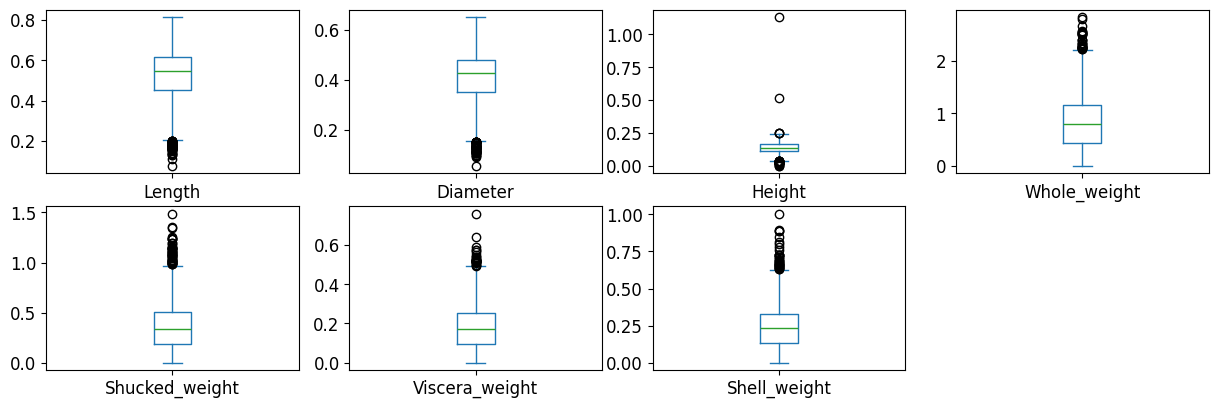

In [206]:
data_mean = X.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(8,4), sharex=False,
sharey=False, fontsize=12, figsize=(15,20))

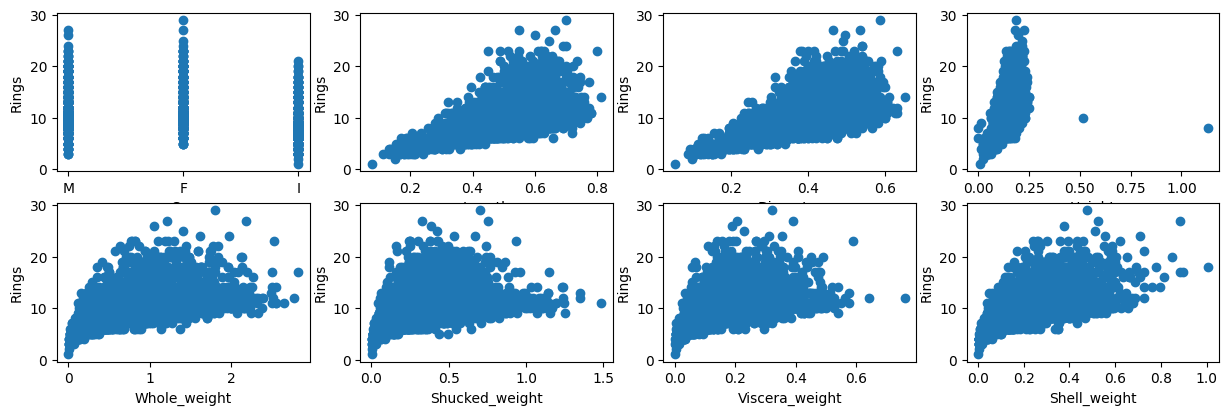

In [207]:
#plot each feature vs rings (column 8) in one figure
fig = plt.figure(figsize=(15, 7))
for i in range(data_mean.shape[1]):
    plt.subplot(3, 4, i+1)
    plt.scatter(data_mean.iloc[:, i], y)
    plt.xlabel(data_mean.columns[i])
    plt.ylabel('Rings')

### Encode 'Sex' column

In [208]:
data_mean = pd.get_dummies(data_mean, columns=['Sex'])
# Drop one dummy_variable to avoid multi collinearity
data_mean.drop(columns=["Sex_I"], inplace=True) 
data_mean

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,True,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,False,False
...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,True,False
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,False,True
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,False,True
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,True,False


### Outlier Removal

In [209]:
outlier_indices = set()
for column in data_mean.columns:
  if column.startswith("Sex"):
    continue
  
  Q1 = data_mean[column].quantile(0.25)
  Q3 = data_mean[column].quantile(0.75)
  IQR = Q3 - Q1
  
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  
  outliers = data_mean[(data_mean[column] < lower_bound) | (data_mean[column] > upper_bound)].index
  outlier_indices.update(outliers)
  
  outliers_sum = ((data_mean[column] < lower_bound) | (data_mean[column] > upper_bound)).sum()
  print(f'{column}: {outliers_sum} outliers')

outlier_indices = list(outlier_indices)

outlier_rm_x = data_mean.drop(index=outlier_indices)
outlier_rm_y = y.drop(index=outlier_indices)

Length: 49 outliers
Diameter: 59 outliers
Height: 29 outliers
Whole_weight: 30 outliers
Shucked_weight: 48 outliers
Viscera_weight: 26 outliers
Shell_weight: 35 outliers


<Axes: >

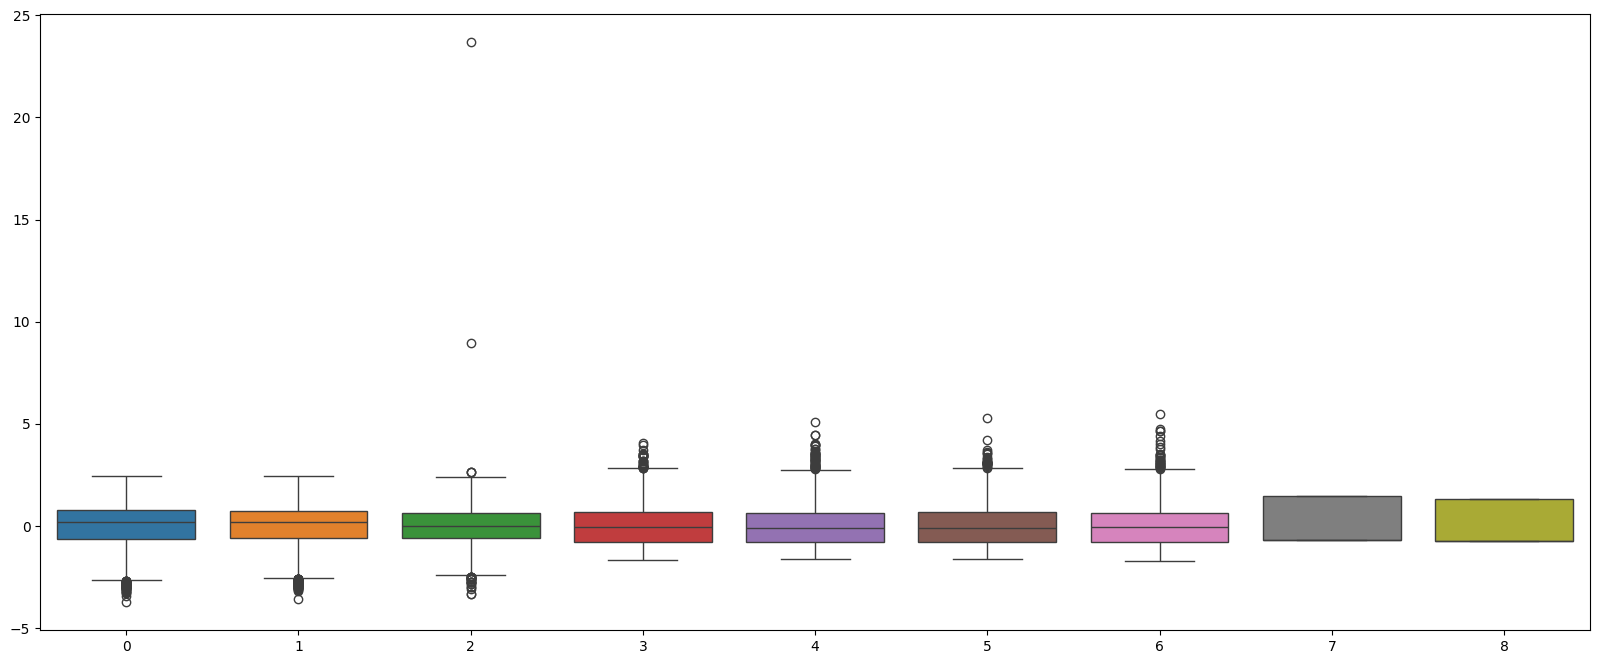

In [210]:
scaler = StandardScaler()
Xs = scaler.fit_transform(data_mean)

# Print features normalised (Xs)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=Xs,ax=ax)

In [211]:
# use original data
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y.values.ravel(), test_size=0.1, random_state=1)

### SVM Regression

In [212]:
from sklearn.svm import SVR

svr_model = SVR(C=1.0, kernel='rbf')
svr_model.fit(Xs_train, y_train.ravel())

# Step 5: Make predictions and evaluate the model
y_pred = svr_model.predict(Xs_test)
print('Test MSE: ', mean_squared_error(y_test, y_pred))

Test MSE:  4.554720381752798


### SVM Regression: K-fold cross validation

In [213]:
## NOTE: in this case, outlier removed data and original data have similar performance

### K-Fold Cross Validation
from sklearn.model_selection import cross_val_score

n_splits = 5

c_values = range(1, 16)

kernals = ['linear', 'poly', 'rbf']

results = []

for kernal in kernals:
  for C in c_values:
    svr_model = SVR(C=C, kernel=kernal)
    scores = cross_val_score(svr_model, Xs_train, y_train, cv=n_splits, scoring='neg_mean_squared_error')
    mse_scores = -scores
    results.append((kernal, C, mse_scores.mean()))
  
optimal_hyper_parameter = min(results, key=lambda x: x[-1])
print(f"Optimal Hyper Parameter from list: {optimal_hyper_parameter}")

optimal_kernal, optimal_c, mse = optimal_hyper_parameter

## test with optimal hyper parameter with test data
svr_model = SVR(C=optimal_c, kernel=optimal_kernal)
svr_model.fit(Xs_train, y_train.ravel())
y_pred = svr_model.predict(Xs_test)
print('Optimized Test MSE: ', mean_squared_error(y_test, y_pred))

Optimal Hyper Parameter from list: ('rbf', 7, np.float64(4.631493906528677))
Optimized Test MSE:  4.24708906377851


### MLP Neural Network

In [214]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import warnings

Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y.values.ravel(), test_size=0.1, random_state=1)

mlp_reg = MLPRegressor(random_state=1, max_iter=300).fit(Xs_train, y_train)

y_pred = mlp_reg.predict(Xs_test)

regressor_mse = mean_squared_error(y_test, y_pred)
print('The Mean Squared Error (MSE) of MLP Regressor is {:.2f}'.format(regressor_mse))


The Mean Squared Error (MSE) of MLP Regressor is 3.90


/Users/stephen/Library/Caches/pypoetry/virtualenvs/labs-env-NHQiDXzZ-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [215]:
# Import necessary libraries
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

mlp_reg = MLPRegressor(random_state=1, max_iter=300)

mse_scorer = make_scorer(mean_squared_error)

scores = cross_val_score(mlp_reg, Xs, y, cv=5, scoring=mse_scorer)


avg = (np.mean(scores), np.std(scores) / np.sqrt(scores.shape[0]))

print("Cross-validated MSE scores:", scores)
print("Average MSE and standard deviation: (%.2f ± %.3f)" % avg)

/Users/stephen/Library/Caches/pypoetry/virtualenvs/labs-env-NHQiDXzZ-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/stephen/Library/Caches/pypoetry/virtualenvs/labs-env-NHQiDXzZ-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/stephen/Library/Caches/pypoetry/virtualenvs/labs-env-NHQiDXzZ-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/s

Cross-validated MSE scores: [8.97750355 2.35526569 5.11113424 3.31946287 3.5018006 ]
Average MSE and standard deviation: (4.65 ± 1.045)


/Users/stephen/Library/Caches/pypoetry/virtualenvs/labs-env-NHQiDXzZ-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Decision Tree Regressor

In [216]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=4)
tree_reg.fit(Xs_train, y_train)

y_test_pred = tree_reg.predict(Xs_test)

print('Test MSE: ', mean_squared_error(y_test, y_test_pred))

Test MSE:  5.89109767796173


### Decision Tree Regressor: K-Fold Validation

In [217]:
### K-Fold Cross Validation
from sklearn.model_selection import KFold, cross_val_score

max_depths = range(1,25)

n_splits = 5

results = []

for depth in max_depths:
  tree_reg = DecisionTreeRegressor(max_depth=depth)
  scores = cross_val_score(tree_reg, Xs_train, y_train, cv=n_splits, scoring='neg_mean_squared_error')
  mse_scores = -scores
  results.append((depth, mse_scores.mean()))

optimal_hyper_parameter = min(results, key=lambda x: x[-1])
print(f"Optimal Hyper Parameter from list: {optimal_hyper_parameter}")

optimal_max_depth, _ = optimal_hyper_parameter

tree_reg = DecisionTreeRegressor(max_depth=optimal_max_depth)
tree_reg.fit(Xs_train, y_train)

y_test_pred = tree_reg.predict(Xs_test)

print('Optimised Test MSE: ', mean_squared_error(y_test, y_test_pred))


Optimal Hyper Parameter from list: (5, np.float64(5.603968407826052))
Optimised Test MSE:  5.354494748195769


### Linear Regression: use outlier removed dataset

In [218]:
# use outlier removed data
Xs_train, Xs_test, y_train, y_test = train_test_split(outlier_rm_x, outlier_rm_y.values.ravel(), test_size=0.2, random_state=1)

### Linear Regression: No Kfold

In [219]:
from sklearn.linear_model import LinearRegression

## Linear regression

# Create linear regression object
lr = LinearRegression()

# Fit the model
lr.fit(Xs_train, y_train)

# Print the coefficients
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

# Predict the target values
y_pred = lr.predict(Xs_test)

# Evaluate the model
mse = mean_squared_error(y_pred, y_test)
print("Mean Squared Error:", mse)

Coefficients: [ -2.64540105   9.55276553  23.82956915   9.47261892 -20.51350671
 -13.19561405   9.13777229   0.81849063   0.83970104]
Intercept: 3.296465589920169
Mean Squared Error: 4.412761395353149


### Linear Regression: K-Fold Cross Validation with HyperParameter Tuning
#### Hyperparameter = Feature Selection

In [220]:
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1)

polynomial_range_num = 5 # Set hyperparameter range of values
kf_inner = KFold(n_splits=polynomial_range_num, shuffle=True, random_state=1) # Create kfold for inner loop

best_degree_list = []   # Best degrees resulting from inner fold
best_val_mse_list = []  # For inner fold
test_mse_list = [] # For outer fold

for train_index, test_index in kf.split(outlier_rm_x):
    X_train, X_test = outlier_rm_x.iloc[train_index], outlier_rm_x.iloc[test_index]
    y_train, y_test = outlier_rm_y.iloc[train_index], outlier_rm_y.iloc[test_index]

    best_degree = 1
    best_val_mse = np.inf

    degree = 1
    for train_index_inner, val_index in kf_inner.split(X_train):
        X_train_inner, X_val = X_train.iloc[train_index_inner],  X_train.iloc[val_index]
        y_train_inner, y_val = y_train.iloc[train_index_inner],  y_train.iloc[val_index]

        # train model with x_train_inner and y_train_inner with n polynomials
        poly_inner = PolynomialFeatures(degree, include_bias=False)

        # Create the pure and interaction terms of degree n
        X_train_inner_poly = poly_inner.fit_transform(X_train_inner)
        X_val_poly = poly_inner.transform(X_val)

        # Train model with polynomial terms
        model = LinearRegression()
        model.fit(X_train_inner_poly, y_train_inner)

        # validate model on validation data and get MSE
        y_pred_inner = model.predict(X_val_poly)
        mse = mean_squared_error(y_val, y_pred_inner)
        print(f"Degree {degree} Validation MSE: {mse:.4}", end=" ---- ")

        # if MSE is best so far, save degree and MSE
        if mse < best_val_mse:
            best_val_mse = mse
            best_degree = degree

        degree += 1
    
    best_degree_list.append(best_degree)
    best_val_mse_list.append(best_val_mse)

    poly = PolynomialFeatures(best_degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_test_pred = model.predict(X_test_poly)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mse_list.append(test_mse)

print("\nSummary of outer folds:")
for i in range(num_splits):
    print(f"Fold {i+1}: Best Degree of {best_degree_list[i]}, Validation MSE = {best_val_mse_list[i]:.4f}, Test MSE = {test_mse_list[i]:.4f}")

print(f"\nAverage Test MSE: {np.mean(test_mse_list):.4f}")



Degree 1 Validation MSE: 5.06 ---- Degree 2 Validation MSE: 4.603 ---- Degree 3 Validation MSE: 5.147 ---- Degree 4 Validation MSE: 26.6 ---- Degree 5 Validation MSE: 4.679e+04 ---- Degree 1 Validation MSE: 4.413 ---- Degree 2 Validation MSE: 4.217 ---- Degree 3 Validation MSE: 7.279 ---- Degree 4 Validation MSE: 17.4 ---- Degree 5 Validation MSE: 1.694e+03 ---- Degree 1 Validation MSE: 5.007 ---- Degree 2 Validation MSE: 4.79 ---- Degree 3 Validation MSE: 5.68 ---- Degree 4 Validation MSE: 27.55 ---- Degree 5 Validation MSE: 1.571e+04 ---- Degree 1 Validation MSE: 4.162 ---- Degree 2 Validation MSE: 4.036 ---- Degree 3 Validation MSE: 6.914 ---- Degree 4 Validation MSE: 34.34 ---- Degree 5 Validation MSE: 1.87e+04 ---- Degree 1 Validation MSE: 4.823 ---- Degree 2 Validation MSE: 4.141 ---- Degree 3 Validation MSE: 4.872 ---- Degree 4 Validation MSE: 73.88 ---- Degree 5 Validation MSE: 3.064e+03 ---- 
Summary of outer folds:
Fold 1: Best Degree of 2, Validation MSE = 4.6034, Test MSE =